**Accident Severity Analysis**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np  
import pandas as pd
import datetime
import os
from sklearn.decomposition import PCA

import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MaxAbsScaler

**Data Import**

In [ ]:
'''
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        filepath = os.path.join(dirname, filename)
        print(filepath)
'''
filepath = '/content/drive/MyDrive/Colab_Notebooks/accident.zip'

In [ ]:
data = pd.read_csv(filepath)
data.columns

Index(['ID', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng',
       'End_Lat', 'End_Lng', 'Distance(mi)', 'Description', 'Number', 'Street',
       'Side', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone',
       'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)',
       'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction',
       'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity',
       'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
       'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal',
       'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight'],
      dtype='object')

In [ ]:
data

,ID,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,Number,Street,Side,City,County,State,Zipcode,Country,Timezone,Airport_Code,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-2716600,3,2016-02-08 00:37:08,2016-02-08 06:37:08,40.10891,-83.09286,40.11206,-83.03187,3.230,Between Sawmill Rd/Exit 20 and OH-315/Olentang...,NaN,Outerbelt E,R,Dublin,Franklin,OH,43017,US,US/Eastern,KOSU,2016-02-08 00:53:00,42.1,36.1,58.0,29.76,10.0,SW,10.4,0.00,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2716601,2,2016-02-08 05:56:20,2016-02-08 11:56:20,39.86542,-84.06280,39.86501,-84.04873,0.747,At OH-4/OH-235/Exit 41 - Accident.,NaN,I-70 E,R,Dayton,Montgomery,OH,45424,US,US/Eastern,KFFO,2016-02-08 05:58:00,36.9,NaN,91.0,29.68,10.0,Calm,NaN,0.02,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night
2,A-2716602,2,2016-02-08 06:15:39,2016-02-08 12:15:39,39.10266,-84.52468,39.10209,-84.52396,0.055,At I-71/US-50/Exit 1 - Accident.,NaN,I-75 S,R,Cincinnati,Hamilton,OH,45203,US,US/Eastern,KLUK,2016-02-08 05:53:00,36.0,NaN,97.0,29.70,10.0,Calm,NaN,0.02,Overcast,False,False,False,False,True,False,False,False,False,False,False,False,False,Night,Night,Night,Day
3,A-2716603,2,2016-02-08 06:15:39,2016-02-08 12:15:39,39.10148,-84.52341,39.09841,-84.52241,0.219,At I-71/US-50/Exit 1 - Accident.,NaN,US-50 E,R,Cincinnati,Hamilton,OH,45202,US,US/Eastern,KLUK,2016-02-08 05:53:00,36.0,NaN,97.0,29.70,10.0,Calm,NaN,0.02,Overcast,False,False,False,False,True,False,False,False,False,False,False,False,False,Night,Night,Night,Day
4,A-2716604,2,2016-02-08 06:51:45,2016-02-08 12:51:45,41.06213,-81.53784,41.06217,-81.53547,0.123,At Dart Ave/Exit 21 - Accident.,NaN,I-77 N,R,Akron,Summit,OH,44311,US,US/Eastern,KAKR,2016-02-08 06:54:00,39.0,NaN,55.0,29.65,10.0,Calm,NaN,NaN,Overcast,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Day,Day
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1516059,A-4239402,2,2019-08-23 18:03:25,2019-08-23 18:32:01,34.00248,-117.37936,33.99888,-117.37094,0.543,At Market St - Accident.,NaN,Pomona Fwy E,R,Riverside,Riverside,CA,92501,US,US/Pacific,KRAL,2019-08-23 17:53:00,86.0,86.0,40.0,28.92,10.0,W,13.0,0.00,Fair,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day
1516060,A-4239403,2,2019-08-23 19:11:30,2019-08-23 19:38:23,32.76696,-117.14806,32.76555,-117.15363,0.338,At Camino Del Rio/Mission Center Rd - Accident.,NaN,I-8 W,R,San Diego,San Diego,CA,92108,US,US/Pacific,KMYF,2019-08-23 18:53:00,70.0,70.0,73.0,29.39,10.0,SW,6.0,0.00,Fair,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day
1516061,A-4239404,2,2019-08-23 19:00:21,2019-08-23 19:28:49,33.77545,-117.84779,33.77740,-117.85727,0.561,At Glassell St/Grand Ave - Accident. in the ri...,NaN,Garden Grove Fwy,R,Orange,Orange,CA,92866,US,US/Pacific,KSNA,2019-08-23 18:53:00,73.0,73.0,64.0,29.74,10.0,SSW,10.0,0.00,Partly Cloudy,False,False,False,False,True,False,False,False,False,False,False,False,False,Day,Day,Day,Day
1516062,A-4239405,2,2019-08-23 19:00:21,2019-08-23 19:29:42,33.99246,-118.40302,33.98311,-118.39565,0.772,At CA-90/Marina Fwy/Jefferson Blvd - Accident.,NaN,San Diego Fwy S,R,Culver City,Los Angeles,CA,90230,US,US/Pacific,KSMO,2019-08-23 18:51:00,71.0,71.0,81.0,29.62,10.0,SW,8.0,0.00,Fair,False,False,False,False,False,False,False,False,False,False,False,False,F

In [ ]:
data

**Feature Extraction**

In [ ]:
X = pd.DataFrame()

In [ ]:
def str_to_datetime(x):
    x = datetime.datetime.strptime(x[:19], '%Y-%m-%d %H:%M:%S')
    return x

def get_acc_len(x):
    x = x.total_seconds() / 60.0
    return x        

In [ ]:
##### Feature extraction and clean-up ######

#start time, end time --> length of accident
end_time = data['End_Time'].apply(str_to_datetime)
start_time = data['Start_Time'].apply(str_to_datetime)
data['Accident_Length'] = end_time - start_time 
X['Accident_Length'] = data['Accident_Length'].apply(get_acc_len)
X['Accident_Length']


X['Accident_Distance'] = data['Distance(mi)']
X['Accident_Distance'].fillna(-500.0, inplace = True) 

X['Temp'] = data['Temperature(F)']
X['Temp'].fillna(-500.0, inplace = True) 
X['Temp']

print(X['Temp'].mean())
print(X['Temp'].max())
print(X['Temp'].min())

X['Humidity'] = data['Humidity(%)']
X['Humidity'].fillna(-10.0, inplace = True) 
X['Humidity']

print(X['Humidity'].mean())
print(X['Humidity'].max())
print(X['Humidity'].min())

X['Precipitation'] = data['Precipitation(in)']
X['Precipitation'].fillna(-10.0, inplace = True) 
X['Precipitation']

print(X['Precipitation'].mean())
print(X['Precipitation'].max())
print(X['Precipitation'].min())

X['Wind_Chill'] = data['Wind_Chill(F)']
X['Wind_Chill'].fillna(-500.0, inplace = True) 
X['Wind_Chill']

print(X['Wind_Chill'].mean())
print(X['Wind_Chill'].max())
print(X['Wind_Chill'].min())

X['Pressure'] = data['Pressure(in)']
X['Pressure'].fillna(-500.0, inplace = True) 
X['Pressure']

print(X['Pressure'].mean())
print(X['Pressure'].max())
print(X['Pressure'].min())

X['Visibility'] = data['Visibility(mi)']
X['Visibility'].fillna(-500.0, inplace = True) 
X['Visibility']

print(X['Visibility'].mean())
print(X['Visibility'].max())
print(X['Visibility'].min())

X['Severity'] = data['Severity']

43.70096394347495
170.6
-500.0
62.41847969478861
100.0
-10.0
-3.361972443121144
24.0
-10.0
-109.40816067132693
113.0
-500.0
16.88459456856929
58.04
-500.0
-5.715391256569642
140.0
-500.0


In [ ]:
X.isna().any()

Accident_Length      False
Accident_Distance    False
Temp                 False
Humidity             False
Precipitation        False
Wind_Chill           False
Pressure             False
Visibility           False
Severity             False
dtype: bool

In [ ]:
unique, counts = np.unique(X['Severity'].values, return_counts=True)
dict(zip(unique, counts))

{1: 28178, 2: 1212382, 3: 161052, 4: 114452}

In [ ]:
def get_new_severity(sev):
  if sev <= 2:
    return 1
  else:
    return 0
'''
X = X[X['Severity'] < 4] 
X = X[X['Severity'] > 1]
'''
X['Severity'] = X['Severity'].apply(get_new_severity)
X.shape

(1516064, 9)

In [ ]:
unique, counts = np.unique(X['Severity'].values, return_counts=True)
dict(zip(unique, counts))

{0: 275504, 1: 1240560}

In [ ]:
X.head()

,Accident_Length,Accident_Distance,Temp,Humidity,Precipitation,Wind_Chill,Pressure,Visibility,Severity
0,360.0,3.230,42.1,58.0,0.00,36.1,29.76,10.0,0
1,360.0,0.747,36.9,91.0,0.02,-500.0,29.68,10.0,1
2,360.0,0.055,36.0,97.0,0.02,-500.0,29.70,10.0,1
3,360.0,0.219,36.0,97.0,0.02,-500.0,29.70,10.0,1
4,360.0,0.123,39.0,55.0,-10.00,-500.0,29.65,10.0,1


In [ ]:
#train/test split
test_len = int(1516064*.10)
X_shuff = X.sample(frac=1,random_state=42)#shuffle data
test_data = X_shuff[:test_len]
train_data = X_shuff[test_len:]

#test_data.to_csv("/content/drive/MyDrive/Colab_Notebooks/accident_test.csv")
#train_data.to_csv("/content/drive/MyDrive/Colab_Notebooks/accident_train.csv")

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler = scaler.fit(train_data.iloc[:,:8].values)
#scaler.transform(train_data.iloc[:,:8].values)
scaler

MinMaxScaler()

In [ ]:
import pickle
#pickle.dump(scaler, open( "/content/drive/MyDrive/Colab_Notebooks/accident_minmax_scaler.pkl", "wb" ) )
scaler = pickle.load( open( "/content/drive/MyDrive/Colab_Notebooks/accident_minmax_scaler.pkl", "rb" ) )

In [ ]:
import torch
from torch.utils import data

class Dataset(data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, data_loc, scaler_loc):
        'Initialization'
        data = pd.read_csv(data_loc)
        self.x = data[['Accident_Length','Accident_Distance','Temp', \
                       'Humidity','Precipitation','Wind_Chill','Pressure', \
                       'Visibility']].values
        self.y = data['Severity'].values

        scaler = pickle.load(open(scaler_loc, "rb" ))
        self.x = scaler.transform(self.x)
        
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.x)

    def __getitem__(self, idx):
        'Generates one sample of data' 
        out_y = np.zeros(2) 
        out_y[self.y[idx]] = 1
        return self.x[idx], out_y



In [ ]:

class Accident_Model(nn.Module):
    def __init__(self):
        super(Accident_Model, self).__init__()
        self.w1 = nn.Linear(8,8,bias=True)
        nn.init.xavier_uniform_(self.w1.weight)
        nn.init.zeros_(self.w1.bias)
        self.bn1 = torch.nn.BatchNorm1d(8)
        
        self.w2 = nn.Linear(8,4,bias=True)
        nn.init.xavier_uniform_(self.w2.weight)
        nn.init.zeros_(self.w2.bias)
        self.bn2 = torch.nn.BatchNorm1d(4)
        
        self.w3 = nn.Linear(4,2,bias=True)
        nn.init.xavier_uniform_(self.w3.weight)
        nn.init.zeros_(self.w3.bias)

    def forward(self, x):
        x = x.float()
        x = self.bn1(F.relu(self.w1(x)))
        
        x = self.bn2(F.relu(self.w2(x)))
        x = self.w3(x)
        return x



In [ ]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score

#class_weights = np.asarray([0.8,1.2])

def sigmoid(x):
    return np.divide(1.0, np.add(1.0, np.exp(-1.0*x)))

In [ ]:
'''
unique, counts = np.unique(train_data['Severity'].values, return_counts=True)
dict(zip(unique, counts))
'''

"\nunique, counts = np.unique(train_data['Severity'].values, return_counts=True)\ndict(zip(unique, counts))\n"

In [ ]:
print((247998+1116460)/(2*247998))
print((247998+1116460)/(2*1116460))

2.7509455721417106
0.6110644358060298


In [ ]:
import pickle
### Dataloader ###
training_set = Dataset("/content/drive/MyDrive/Colab_Notebooks/accident_train.csv","/content/drive/MyDrive/Colab_Notebooks/accident_minmax_scaler.pkl")
training_generator = data.DataLoader(training_set, batch_size=65536, shuffle=True)

test_set = Dataset("/content/drive/MyDrive/Colab_Notebooks/accident_test.csv","/content/drive/MyDrive/Colab_Notebooks/accident_minmax_scaler.pkl")
test_generator = data.DataLoader(test_set, batch_size=int(1516064*.10), shuffle=False)

In [ ]:

net = Accident_Model()

optimizer = torch.optim.Adam(net.parameters(), lr=0.001)#,weight_decay=0.95)
criterion = nn.BCEWithLogitsLoss(weight=torch.Tensor([2.7509455721417106,0.6110644358060298]))
current_loss = 0
train_loss = []
test_loss_lst = []

for epoch in np.arange(10):
    #x_layer_pred = []
    print("Starting epoch:",epoch)
    for batch_idx,(batch, labels) in enumerate(training_generator):
      net.train()
      #zero gradient
      optimizer.zero_grad()

      #perform forward pass
      outputs = net(batch).float()

      #compute loss
      #print(outputs[:,0].long())
      loss = criterion(outputs,np.squeeze(labels).float())

      #perform backward pass
      loss.backward()

      #perform optimization
      optimizer.step()
      current_loss += loss.item()

      if batch_idx % 10 == 9:
        net.eval()
        with torch.no_grad():
          for test_batch, test_labels in test_generator:

              test_outputs = net(test_batch)
              #test_outputs_ = F.sigmoid(test_outputs.detach())
              test_loss = criterion(test_outputs,np.squeeze(test_labels).float())
              
              
              print("Train Loss: ", current_loss / 10)
              print("Test Loss: ", test_loss.item())

              train_loss.append(current_loss / 10)
              test_loss_lst.append(test_loss)


              
              print(confusion_matrix(sigmoid(outputs.detach()).argmax(1), labels.detach().argmax(1)))
              #print(precision_recall_fscore_support(labels.detach().argmax(1), sigmoid(outputs.detach()).argmax(1), average=None))
              print("\n")
              print(confusion_matrix(sigmoid(test_outputs.detach()).argmax(1), test_labels.detach().argmax(1)))
              #print(precision_recall_fscore_support(test_labels.detach().argmax(1), sigmoid(test_outputs.detach()).argmax(1), average=None))
              
              #print(labels)
              #accuracy = accuracy_score(labels, sigmoid(outputs.detach()).argmax(1))
              #print("Accuracy Train: ", accuracy)
              accuracy = accuracy_score(test_labels.argmax(1), sigmoid(test_outputs.detach()).argmax(1))
              print("Accuracy Test: ", accuracy)
              #break;
          current_loss = 0.0


Starting epoch: 0
Train Loss:  1.2566030740737915
Test Loss:  1.0313462018966675
[[ 5900 14085]
 [ 6029 39522]]


[[    19     79]
 [ 27487 124021]]
Accuracy Test:  0.8181734232154401
Train Loss:  1.2110936641693115
Test Loss:  0.9879961013793945
[[ 6224 14844]
 [ 5728 38740]]


[[   716   3488]
 [ 26790 120612]]
Accuracy Test:  0.800284949144493
Starting epoch: 1
Train Loss:  1.27997944355011
Test Loss:  0.992786169052124
[[ 6585 16018]
 [ 5361 37572]]


[[  5294  13046]
 [ 22212 111054]]
Accuracy Test:  0.7674366449876654
Train Loss:  1.1297585010528564
Test Loss:  1.0120999813079834
[[ 6565 16030]
 [ 5410 37531]]


[[  5796  14195]
 [ 21710 109905]]
Accuracy Test:  0.7631690038652824
Starting epoch: 2
Train Loss:  1.2149051547050476
Test Loss:  1.0289912223815918
[[ 6460 15941]
 [ 5424 37711]]


[[  4587  11851]
 [ 22919 112249]]
Accuracy Test:  0.770655514953234
Train Loss:  1.0850098133087158
Test Loss:  1.0482741594314575
[[ 6599 16115]
 [ 5371 37451]]


[[  7492  18675]
 [ 20014

In [ ]:
pickle.dump(train_loss, open( "/content/drive/MyDrive/Colab_Notebooks/accident_train_loss.pkl", "wb" ))
pickle.dump(test_loss_lst, open( "/content/drive/MyDrive/Colab_Notebooks/accident_test_loss.pkl", "wb" ))

In [ ]:
torch.save(net.state_dict(), "/content/drive/MyDrive/Colab_Notebooks/accident_mlp_10_epoch.pt")


In [ ]:
model = Accident_Model()
model.load_state_dict(torch.load("/content/drive/MyDrive/Colab_Notebooks/accident_mlp_10_epoch.pt"))
model.eval()

Accident_Model(
  (w1): Linear(in_features=8, out_features=8, bias=True)
  (bn1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (w2): Linear(in_features=8, out_features=4, bias=True)
  (bn2): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (w3): Linear(in_features=4, out_features=2, bias=True)
)

In [ ]:
import pickle
### Dataloader ###
training_set = Dataset("/content/drive/MyDrive/Colab_Notebooks/accident_train.csv","/content/drive/MyDrive/Colab_Notebooks/accident_minmax_scaler.pkl")
training_generator = data.DataLoader(training_set, batch_size=int(1516064*.90)+1, shuffle=True)

#test_set = Dataset("/content/drive/MyDrive/Colab_Notebooks/accident_test.csv","/content/drive/MyDrive/Colab_Notebooks/accident_minmax_scaler.pkl")
#test_generator = data.DataLoader(test_set, batch_size=int(1516064*.10), shuffle=False)

In [ ]:
train_data, train_labels = next(iter(training_generator))
train_outputs = net(train_data).float()

In [ ]:
print(confusion_matrix(sigmoid(train_outputs.detach()).argmax(1), train_labels.detach().argmax(1)))

[[102609 236906]
 [145389 879554]]


In [ ]:
print(precision_recall_fscore_support(sigmoid(train_outputs.detach()).argmax(1), train_labels.detach().argmax(1), average=None))

(array([0.4137493, 0.7878061]), array([0.30222229, 0.85814918]), array([0.3492995 , 0.82147452]), array([ 339515, 1024943]))


In [ ]:
test_set = Dataset("/content/drive/MyDrive/Colab_Notebooks/accident_test.csv","/content/drive/MyDrive/Colab_Notebooks/accident_minmax_scaler.pkl")
test_generator = data.DataLoader(test_set, batch_size=int(1516064*.10)+1, shuffle=True)


In [ ]:
test_data, test_labels = next(iter(test_generator))
test_outputs = net(test_data).float()

In [ ]:
print(confusion_matrix(sigmoid(test_outputs.detach()).argmax(1), test_labels.detach().argmax(1)))

[[11165 25662]
 [16341 98438]]


In [ ]:
print(precision_recall_fscore_support(sigmoid(test_outputs.detach()).argmax(1), test_labels.detach().argmax(1), average=None))

(array([0.40591144, 0.79321515]), array([0.3031743 , 0.85763075]), array([0.34710024, 0.82416621]), array([ 36827, 114779]))


In [ ]:
(array([0.4534647 , 0.74778405]), array([0.28494734, 0.86058999]), array([0.34997685, 0.8002311 ]), array([ 43773, 107833]))


In [ ]:
11165/(11165+25662)

0.3031743014636001

In [ ]:
((98438/(16341+98438))+(11165/(11165+25662)))/2

0.5804025263667159

In [ ]:
test_data = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/accident_test.csv")
train_data = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/accident_train.csv")

In [ ]:
train_data.head()

,Unnamed: 0,Accident_Length,Accident_Distance,Temp,Humidity,Precipitation,Wind_Chill,Pressure,Visibility,Severity
0,793963,15.0,0.000,91.0,32.0,0.0,91.0,29.84,10.0,1
1,1385960,360.0,4.937,36.0,41.0,-10.0,29.0,29.76,10.0,1
2,70569,360.0,0.000,53.1,47.0,-10.0,-500.0,30.31,10.0,1
3,290435,266.5,5.216,42.0,53.0,0.0,36.0,25.23,10.0,1
4,186924,360.0,0.001,62.6,88.0,-10.0,-500.0,30.07,10.0,0


In [ ]:
import xgboost as xgb
# read in data
dtrain = xgb.DMatrix(train_data[['Accident_Length','Accident_Distance','Temp','Humidity','Precipitation','Wind_Chill','Pressure','Visibility']], label=train_data['Severity'])
dtest = xgb.DMatrix(test_data[['Accident_Length','Accident_Distance','Temp','Humidity','Precipitation','Wind_Chill','Pressure','Visibility']])
# specify parameters via map
param = {'max_depth':8, 'eta':1, 'objective':'binary:logistic' }
num_round = 10
bst = xgb.train(param, dtrain, num_round)
# make prediction
preds = bst.predict(dtest)

In [ ]:
print(confusion_matrix(np.round(preds), test_data['Severity']))

[[  7373   5165]
 [ 20133 118935]]


In [ ]:
print(precision_recall_fscore_support(np.round(preds), test_data['Severity'], average=None))

(array([0.26805061, 0.95838034]), array([0.58805232, 0.8552291 ]), array([0.36824493, 0.90387129]), array([ 12538, 139068]))


In [ ]:
import xgboost as xgb
# read in data
dtrain = xgb.DMatrix(train_data.detach().numpy(), label=train_labels.detach().numpy())
dtest = xgb.DMatrix(test_data.detach().numpy())
# specify parameters via map
param = {'max_depth':8, 'eta':1, 'objective':'binary:logistic' }
num_round = 10
bst = xgb.train(param, dtrain, num_round)
# make prediction
preds = bst.predict(dtest)

In [ ]:
print(confusion_matrix(np.round(preds), test_labels.detach().numpy().argmax(1)))

[[15281 62012]
 [12225 62088]]


In [ ]:
print(precision_recall_fscore_support(np.round(preds), test_labels.detach().numpy().argmax(1), average=None))

(array([0.55555152, 0.5003062 ]), array([0.19770225, 0.83549312]), array([0.29162492, 0.62584609]), array([77293, 74313]))


In [ ]:
import xgboost as xgb
# read in data
dtrain = xgb.DMatrix(train_outputs.detach().numpy(), label=train_labels.detach().numpy())
dtest = xgb.DMatrix(test_outputs.detach().numpy())
# specify parameters via map
param = {'max_depth':4, 'eta':1, 'objective':'binary:logistic' }
num_round = 4
bst = xgb.train(param, dtrain, num_round)
# make prediction
preds = bst.predict(dtest)

In [ ]:
print(confusion_matrix(np.round(preds), test_labels.detach().numpy().argmax(1)))

[[12473 31300]
 [15033 92800]]


In [ ]:
print(precision_recall_fscore_support(np.round(preds), test_labels.detach().numpy().argmax(1), average=None))

(array([0.4534647 , 0.74778405]), array([0.28494734, 0.86058999]), array([0.34997685, 0.8002311 ]), array([ 43773, 107833]))


In [ ]:
92800/(15033+92800)

0.8605899863678095

In [ ]:
import pickle
train_loss = pickle.load( open( "/content/drive/MyDrive/Colab_Notebooks/accident_train_loss.pkl", "rb" ) )
test_loss = pickle.load( open( "/content/drive/MyDrive/Colab_Notebooks/accident_test_loss.pkl", "rb" ) )

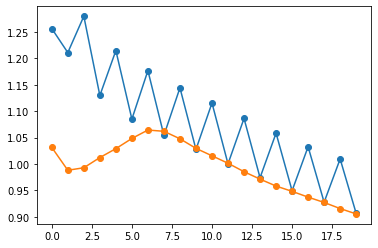

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
x = np.arange(len(train_loss))
plt.plot(x, train_loss, '-o')
plt.plot(x, test_loss, '-o')
plt.show()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])